# Pembuatan Model Pendeteksian Masker Wajah Menggunakan Resnet50
oleh:
- Elshe Erviana Angely (5025201050)
- Rere Arga Dewanata (5025201078)

## Import Libraries

In [1]:
# Import necessary modules and functions from TensorFlow Keras for building the model and preprocessing images.
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, GlobalAveragePooling2D
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Import NumPy and Pandas for data manipulation.
import numpy as np
import pandas as pd

# Import regular expression module for pattern matching.
import re

# Define Model

In [2]:
# Define the number of classes for the classification task.
num_classes = 2

# Create a sequential model, a linear stack of layers.
model = Sequential()

# Add ResNet50 pre-trained on ImageNet without the top classification layer, using average pooling.
model.add(ResNet50(include_top=False, pooling='avg', weights='imagenet'))

# Add a dense layer with softmax activation function for final classification into the specified number of classes.
model.add(Dense(num_classes, activation='softmax'))

# Set the first layer (ResNet50) to be untrainable, meaning its weights will not be updated during training.
model.layers[0].trainable = False


94765736/94765736 [==============================] - 1s 0us/step


# Compile Model

In [3]:
# Compile the model with Stochastic Gradient Descent (SGD) optimizer, categorical crossentropy loss function, and accuracy metric.
model.compile(optimizer='sgd',
              loss='categorical_crossentropy',
              metrics=['accuracy'])


# Image Augmentation and Data Preprocessing


In [4]:
# Create an image data generator with data augmentation, including preprocessing input, horizontal flipping, and random shifts in width and height.
data_generator_with_aug = ImageDataGenerator(preprocessing_function=preprocess_input,
                                             horizontal_flip=True,
                                             width_shift_range=0.1,
                                             height_shift_range=0.1)

# Create an image data generator without data augmentation, only including preprocessing input.
data_generator_no_aug = ImageDataGenerator(preprocessing_function=preprocess_input)


# Load Image Dataset

In [5]:
# Import the drive module from the google.colab library to mount Google Drive.
from google.colab import drive

# Mount Google Drive to the '/content/drive/' directory in the Colab environment.
drive.mount('/content/drive/')

Mounted at /content/drive/


In [6]:
#define image size height and width
image_size = 224

dataset_path = "/content/drive/MyDrive/ViskomPengayaan/Dataset"
trainset_path = dataset_path + '/train'
validationset_path = dataset_path + '/val'

classification_classes = ['with_mask','without_mask']

#Prepare training image
train_generator = data_generator_with_aug.flow_from_directory(
                                        directory=trainset_path,
                                        classes = classification_classes,
                                        target_size=(image_size, image_size),
                                        batch_size=10,
                                        class_mode='categorical')
#Prepare validation image
validation_generator = data_generator_no_aug.flow_from_directory(
                                        directory=validationset_path,
                                        classes = classification_classes,
                                        target_size=(image_size, image_size),
                                        class_mode='categorical')

Found 1200 images belonging to 2 classes.
Found 600 images belonging to 2 classes.


# Train the Model

In [7]:
# Train the model using data generated batch by batch by train_generator.
# Set the number of steps per epoch to 60, epochs to 4, validation data from validation_generator,
# and validation steps to 1.
fit_stats = model.fit_generator(train_generator,
                                steps_per_epoch=60,
                                epochs=4,
                                validation_data=validation_generator,
                                validation_steps=1)


<ipython-input-7-3360caa50766>:4: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  fit_stats = model.fit_generator(train_generator,


Epoch 1/4
60/60 [==============================] - 140s 2s/step - loss: 0.2172 - accuracy: 0.9050 - val_loss: 0.2087 - val_accuracy: 0.9375
Epoch 2/4
60/60 [==============================] - 74s 1s/step - loss: 0.0566 - accuracy: 0.9817 - val_loss: 0.0217 - val_accuracy: 1.0000
Epoch 3/4
60/60 [==============================] - 51s 860ms/step - loss: 0.0366 - accuracy: 0.9933 - val_loss: 0.0287 - val_accuracy: 1.0000
Epoch 4/4
60/60 [==============================] - 37s 619ms/step - loss: 0.0365 - accuracy: 0.9867 - val_loss: 0.0562 - val_accuracy: 0.9688


# Test the Model

In [8]:
# Create a test data generator without data augmentation, loading images from the specified directory,
# resizing them to the specified target size, with a batch size of 10, no class mode, and no shuffling.

testset_path = dataset_path + '/test'

test_generator = data_generator_no_aug.flow_from_directory(
    directory=testset_path,
    target_size=(image_size, image_size),
    batch_size=10,
    class_mode=None,
    shuffle=False
)

# Generate predictions for the test data using the trained model, iterating over the test generator
# for a number of steps equal to the length of the test generator, with verbose output.
pred = model.predict_generator(test_generator, steps=len(test_generator), verbose=1)

# Round the predictions class to the nearest integer (0 or 1).
cl = np.round(pred)

# Get the filenames of the test images.
filenames = test_generator.filenames

# Initialize lists to store the real classes and predicted classes.
real_class = []
for file in filenames:
    if re.search("with_mask", file):
        real_class.append(1.0)
    else:
        real_class.append(0.0)

# Extract the predicted class probabilities for class 0 (without mask).
predicted_class = cl[:, 0]

# Create a DataFrame to store the results, including filenames, predicted probabilities, predicted classes,
# and real classes.
results = pd.DataFrame({"file": filenames, "pr": pred[:, 0], "pred_class": predicted_class, "real_class": real_class})


Found 200 images belonging to 2 classes.


<ipython-input-8-35a9e972211f>:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  pred = model.predict_generator(test_generator, steps=len(test_generator), verbose=1)


20/20 [==============================] - 41s 2s/step


In [9]:
results

,file,pr,pred_class,real_class
0,with_mask/train_00000859.jpg,0.996174,1.0,1.0
1,with_mask/train_00000860.jpg,0.999905,1.0,1.0
2,with_mask/train_00000861.jpg,1.000000,1.0,1.0
3,with_mask/train_00000862.jpg,0.999866,1.0,1.0
4,with_mask/train_00000863.jpg,1.000000,1.0,1.0
...,...,...,...,...
195,without_mask/53_0_0_20170120223141508.jpg,0.002068,0.0,0.0
196,without_mask/53_0_0_20170120223144035.jpg,0.000178,0.0,0.0
197,without_mask/5_0_3_20170119212110570.jpg,0.018124,0.0,0.0
198,without_mask/5_1_3_20170119151512160.jpg,0.104723,0.0,0.0


## Calculate Model Accuracy

In [10]:
# Calculate the accuracy by counting the number of correct predictions (where the predicted class matches the real class)
# using a generator expression, and dividing by the total number of samples (length of real_class).
res = sum(1 for x, y in zip(real_class, predicted_class) if x == y) / len(real_class)

# Print the calculated accuracy.
print("Accuracy :", res)


Accuracy : 0.99


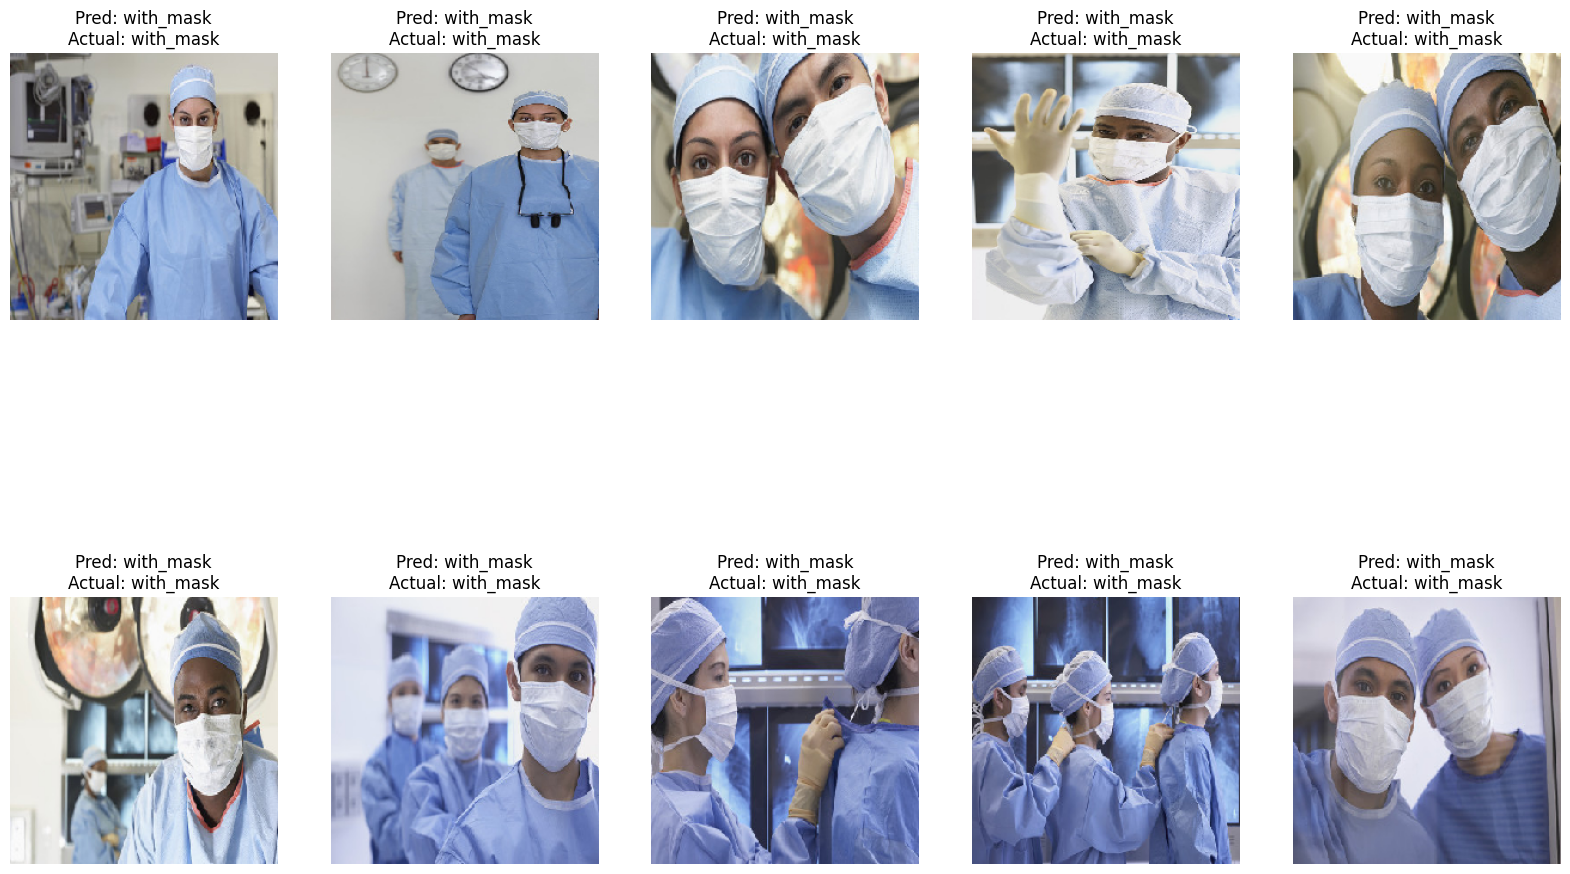

In [21]:
import matplotlib.pyplot as plt
import os
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# Function to plot images with predicted and actual class names
def plot_predictions(images, predictions, actuals, class_labels, n=10):
    plt.figure(figsize=(20, 20))
    for i in range(n):
        img = load_img(images[i], target_size=(image_size, image_size))
        plt.subplot(3, 5, i+1)
        plt.imshow(img)
        pred_label = class_labels[int(predictions[i])]
        actual_label = class_labels[int(actuals[i])]
        plt.title(f"Pred: {pred_label}\nActual: {actual_label}")
        plt.axis('off')
    plt.show()

# Get the first few rows of the results DataFrame to show predictions
sample_results = results.head(10)

# Construct the full file paths for the sample images
sample_images = [os.path.join(testset_path, fname) for fname in sample_results['file']]

# Extract the predicted and real classes for the sample images
sample_pred_classes = sample_results['pred_class'].values
sample_real_classes = sample_results['real_class'].values

# Define class labels
class_labels = ['without_mask', 'with_mask']

# Plot the sample predictions
plot_predictions(sample_images, sample_pred_classes, sample_real_classes, class_labels, n=10)


In [22]:
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score

# Calculate accuracy
accuracy = accuracy_score(results['real_class'], results['pred_class'])

# Calculate recall
recall = recall_score(results['real_class'], results['pred_class'])

# Calculate precision
precision = precision_score(results['real_class'], results['pred_class'])

# Calculate F1 score
f1 = f1_score(results['real_class'], results['pred_class'])

# Print the results
print(f"Accuracy: {accuracy:.4f}")
print(f"Recall: {recall:.4f}")
print(f"Precision: {precision:.4f}")
print(f"F1 Score: {f1:.4f}")


Accuracy: 0.9900
Recall: 1.0000
Precision: 0.9804
F1 Score: 0.9901


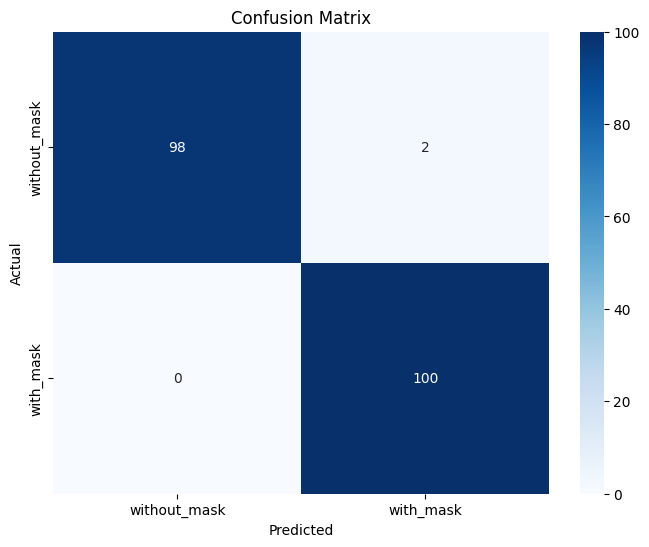

In [23]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Compute confusion matrix
conf_matrix = confusion_matrix(results['real_class'], results['pred_class'])

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


In [24]:
from sklearn.metrics import classification_report

# Generate classification report
class_report = classification_report(results['real_class'], results['pred_class'], target_names=class_labels)
print("Classification Report:\n", class_report)


Classification Report:
               precision    recall  f1-score   support

without_mask       1.00      0.98      0.99       100
   with_mask       0.98      1.00      0.99       100

    accuracy                           0.99       200
   macro avg       0.99      0.99      0.99       200
weighted avg       0.99      0.99      0.99       200



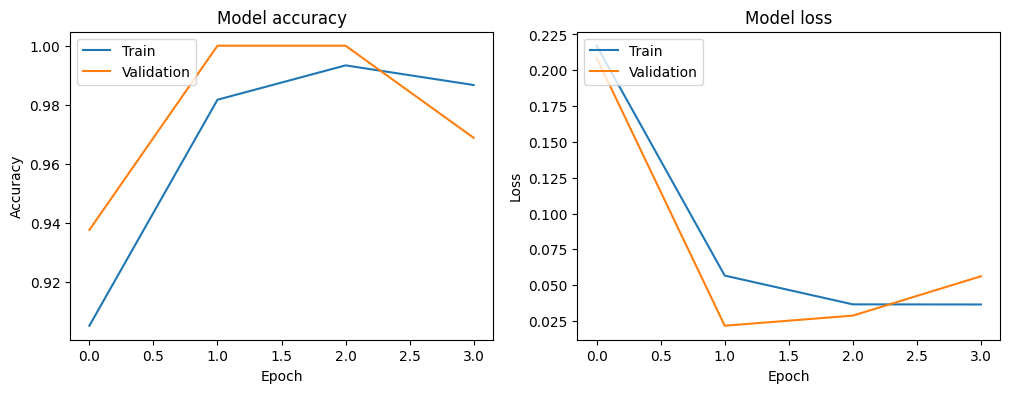

In [27]:
# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(fit_stats.history['accuracy'])
plt.plot(fit_stats.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(fit_stats.history['loss'])
plt.plot(fit_stats.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()


## Save Model

In [11]:
model.save('MaskDetectionModel.keras')